# Multas de tránsito en USA

Las infracciones de tráfico siguieron a la invención del automóvil: la primera multa de tráfico en los Estados Unidos supuestamente se le dio a un taxista de la ciudad de Nueva York el 20 de mayo de 1899 por ir a la vertiginosa velocidad de 12 millas por hora (aprox. 19.3 km/h). Desde entonces, se han emitido innumerables citaciones por infracciones de tránsito en todo el país, y los estados han cosechado miles de millones de dólares en ingresos de los infractores.

Las infracciones de tránsito generalmente se dividen en tipos de infracciones mayores y menores. El tipo más leve son las infracciones de estacionamiento, que no se cuentan en el historial de manejo, aunque una persona puede ser arrestada por infracciones no pagadas.

El tipo más común de infracción de tránsito es la infracción del límite de velocidad. Los límites de velocidad están definidos por estado.

El dataset fue obtenido de Kaggle: https://www.kaggle.com/datasets/felix4guti/traffic-violations-in-usa

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils import LSTMModel, Optimization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

### Gráfica de la serie original - Lectura de datos

In [2]:
# Carga del dataset
inputfile="Traffic_Violations.csv"
print('Input file is:', inputfile)
df = pd.read_csv(inputfile)
df = df.rename(columns={'Date Of Stop': 'fecha_detencion'})
df = df.set_index(pd.DatetimeIndex(df['fecha_detencion']))
df.sort_index(ascending=True, inplace=True)
df["Count"] = 1
df = df["Count"]

df = df.groupby("fecha_detencion").count()
# Informacion general
df.info()


Input file is: Traffic_Violations.csv
<class 'pandas.core.series.Series'>
DatetimeIndex: 1822 entries, 2012-01-01 to 2016-12-27
Series name: Count
Non-Null Count  Dtype
--------------  -----
1822 non-null   int64
dtypes: int64(1)
memory usage: 28.5 KB


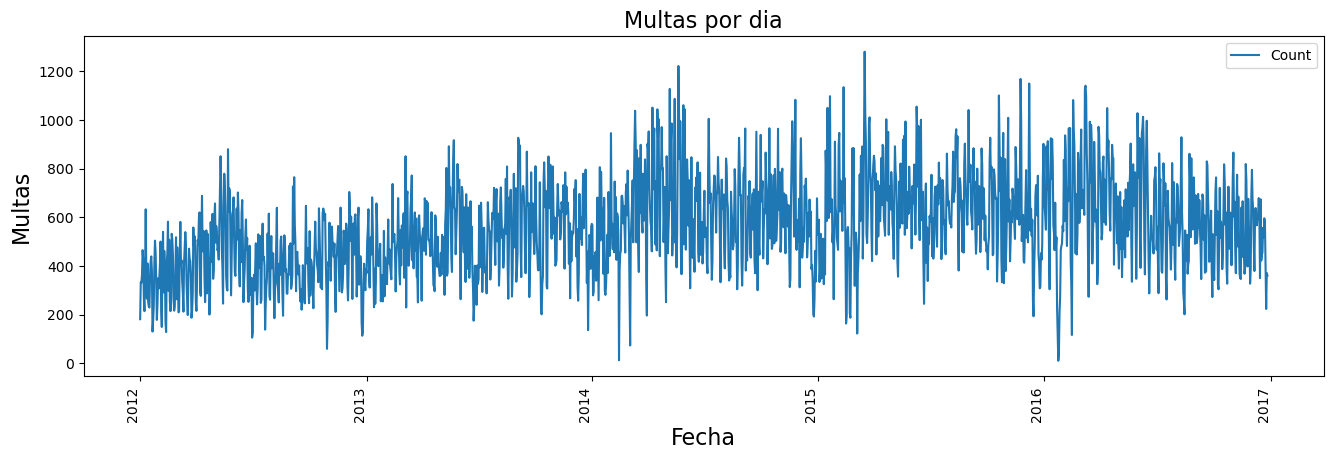

In [3]:
matplotlib.rcParams['figure.figsize'] = [16,5]
plt.figure()
ax = df.plot(y='Count', rot=90)
ax.set_title("Multas por dia", fontsize=16)
ax.set_ylabel("Multas", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
plt.legend(loc='best')
plt.show()

In [4]:
df_features = df.copy()
df_features = df_features.reset_index()

# Seleccionamos la columna 'Count'
dataset = df_features.iloc[:, 1]

# Cambiamos la forma de la columna a (x,1)
dataset = dataset.to_numpy().reshape(-1, 1)

dataset.shape

(1822, 1)

In [5]:
# fija la raiz para poder repeir el experimento
tf.random.set_seed(7)

In [6]:
# normaliza el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
# Separa en train y test
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(f'Datos para entrenamiento : {len(train)}, Datos para test : {len(test)}')

Datos para entrenamiento : 1275, Datos para test : 547


In [8]:
# convierte el arreglo en un dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        
    return np.array(dataX), np.array(dataY)

In [9]:
# reshape en X=t y Y=t+1 para netrenar el modelo para predecir a un paso
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
# crea una red LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dense(1))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compila y hace el fit de la red LSTM

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


2023-04-16 17:00:27.415407: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1273/1273 - 2s - loss: 0.0213 - 2s/epoch - 1ms/step
Epoch 2/100
1273/1273 - 1s - loss: 0.0174 - 839ms/epoch - 659us/step
Epoch 3/100
1273/1273 - 1s - loss: 0.0173 - 841ms/epoch - 660us/step
Epoch 4/100
1273/1273 - 1s - loss: 0.0170 - 844ms/epoch - 663us/step
Epoch 5/100
1273/1273 - 1s - loss: 0.0172 - 836ms/epoch - 657us/step
Epoch 6/100
1273/1273 - 1s - loss: 0.0172 - 835ms/epoch - 656us/step
Epoch 7/100
1273/1273 - 1s - loss: 0.0170 - 840ms/epoch - 660us/step
Epoch 8/100
1273/1273 - 1s - loss: 0.0171 - 838ms/epoch - 658us/step
Epoch 9/100
1273/1273 - 1s - loss: 0.0170 - 837ms/epoch - 658us/step
Epoch 10/100
1273/1273 - 1s - loss: 0.0170 - 838ms/epoch - 658us/step
Epoch 11/100
1273/1273 - 1s - loss: 0.0168 - 836ms/epoch - 657us/step
Epoch 12/100
1273/1273 - 1s - loss: 0.0170 - 834ms/epoch - 655us/step
Epoch 13/100
1273/1273 - 1s - loss: 0.0171 - 833ms/epoch - 654us/step
Epoch 14/100
1273/1273 - 1s - loss: 0.0170 - 835ms/epoch - 656us/step
Epoch 15/100
1273/1273 - 1s - loss: 0.0168 - 8

In [14]:
# Predecir 
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# El modelo fue entrenado con la serie escalada. La prediccion devuelve una serie escalada.
# Para volver a la serie original hay que hacer el escalado inverso
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calcula root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

18/18 [==============================] - 0s 795us/step
Train Score: 163.71 RMSE
Test Score: 173.16 RMSE


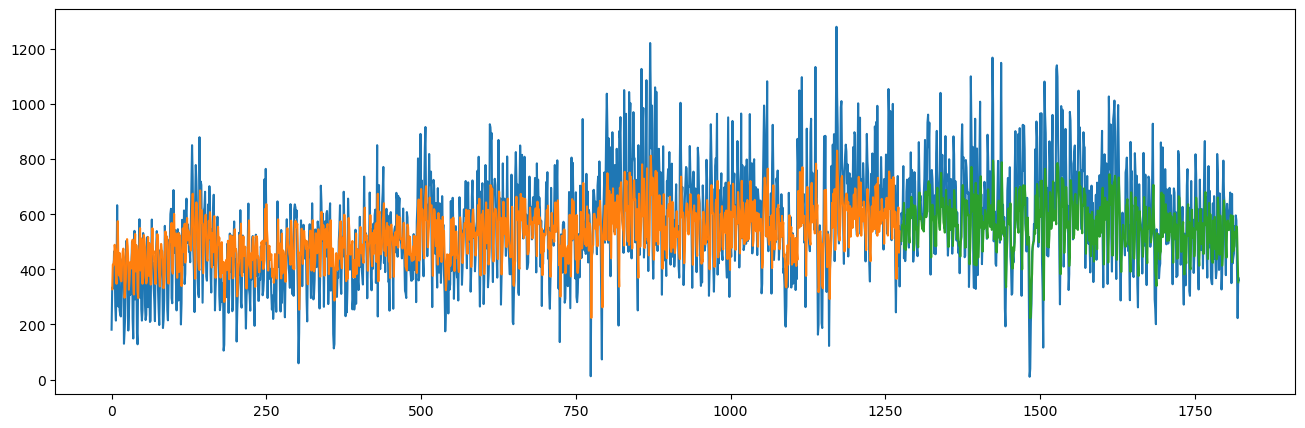

In [15]:
# desplaza la prediccion en entrenamiento para mostrarlo
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# desplaza la prediccion en testing para mostrarlo
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plotea la serie, el entenamiento y la prediccion
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

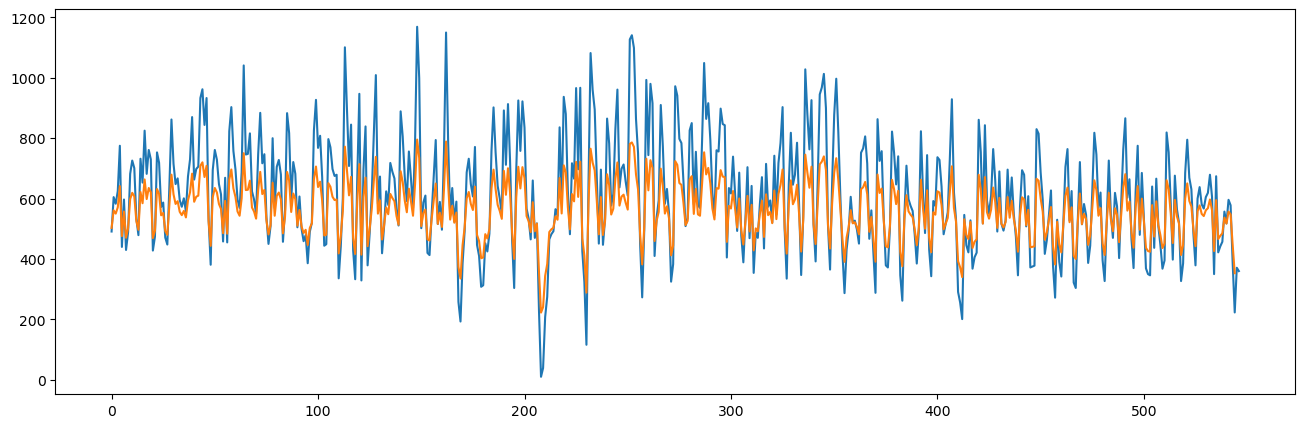

In [16]:
# Muestra solo la prediccion
plt.plot(scaler.inverse_transform(test))
plt.plot(testPredict)
plt.show()

In [17]:
max(scaler.inverse_transform(test))

array([1169.])

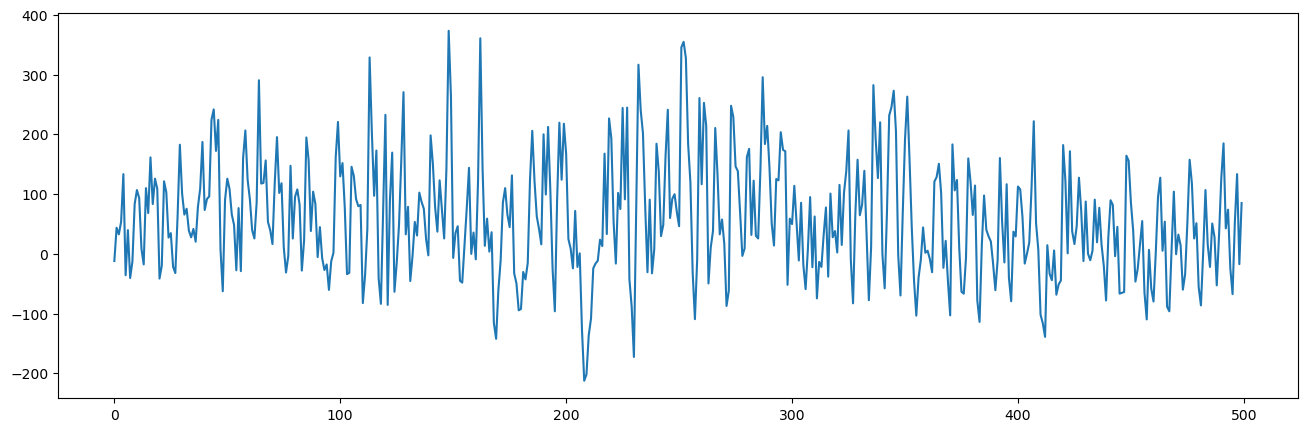

In [22]:
# Grafico de Diferencia  en test
dif = scaler.inverse_transform(test[:500])-testPredict[:500]
plt.plot(dif) 
plt.show()